# Modeling Temporal Effects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
import random
from sklearn.preprocessing import StandardScaler

In [2]:
from project_helper import *

## Separate Data Subsets

In [3]:
# read source data
df = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [4]:
# save feature and label columns for later
label_col = 'murder_per_100_k'
feature_cols = df.drop(['MSA_orig', 'MSA_corr', 'MSA_abbr', 'year']+[label_col], axis=1).columns

# drop extra MSA names
df = df.drop(['MSA_orig', 'MSA_corr'], axis=1)

In [5]:
# remove outliers with atypically high murder rates
df = df[df.MSA_abbr != 'NEW_ORLEANS_LA']
df = df[(df.MSA_abbr != 'MEMPHIS_TN') | (df.year != 2016)]
df = df[(df.MSA_abbr != 'BATON_ROUGE_LA') | (df.year != 2007)]

In [6]:
# get dummies
df_d = pd.get_dummies(df, columns=['MSA_abbr'])
df_d['MSA_abbr'] = df.MSA_abbr

# store names of msa columns
msa_cols = [c for c in df_d.columns if c not in df.columns]

# train test split by year
split_yr = 2013

train_idxs = list((df_d.year <= split_yr).nonzero()[0])
test_idxs = list((df_d.year > split_yr).nonzero()[0])

print('Len train: {}'.format(len(train_idxs)))
print('Len test: {}'.format(len(test_idxs)))

Len train: 648
Len test: 268


In [7]:
# standardize features, fitting based on train rows only
standardizer = StandardScaler().fit(df_d.iloc[train_idxs][feature_cols])
df_fstd = pd.DataFrame(standardizer.transform(df_d[feature_cols]), columns=feature_cols)

# combine with previous MSA encodings and year
df_s = pd.concat([df_d.drop(feature_cols, axis=1).reset_index(drop=True), df_fstd.reset_index(drop=True)], axis=1)

# split into train and test dataframes
df_train = df_s.iloc[train_idxs]
df_test = df_s.iloc[test_idxs]

print('Len data: {}'.format(len(df_train)))
print('Len test: {}'.format(len(df_test)))

Len data: 648
Len test: 268


In [8]:
def moving_average(df, ma_yrs, cols_to_smooth):
    '''
    Smooth data by averaging, for each observation, the values within each MSA
    across a moving window of [ma_yrs] years.
    '''
   
    # the min and max years in the dataset
    min_yr = int(df.year.min())
    max_yr = int(df.year.max())

    # get the list of unique MSAs to cycle through
    MSAs = df.MSA_abbr.unique()

    # holds list of pd.Series to become dataframe
    smoothed_rows = []
    
    # loop through MSAs
    for m in MSAs:
        
        # loop through years starting at the lowest
        for year in range(min_yr, max_yr+1):
            
            # bounds for searching years
            yr_l = max(year-(ma_yrs-1)/2, min_yr)
            yr_h = min(year+(ma_yrs-1)/2, max_yr)
            
            # get window of data
            window = df[(df.year >= yr_l) & (df.year <= yr_h) & (df.MSA_abbr == m)][feature_cols]
            
            # source row
            row_id = ((df.year == year) & (df.MSA_abbr == m)).nonzero()[0]

            if row_id.size > 0:
                row_id = row_id[0]
                row_data = df.iloc[row_id]

                # fill columns with window means and save it
                row_data[feature_cols] = window.mean()
                smoothed_rows.append(row_data)
            
    return pd.DataFrame(smoothed_rows)

In [9]:
# apply smoothing only to training data
df_train_smoothed = moving_average(df_train, 5, feature_cols+[label_col])

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/pandas/core/series.py:817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_labels(key, value)


In [10]:
# year still needs to be rescaled for all datasets
# rescale to approx [0.1 , 1.0]
df_train['year'] = (df_train['year']-2005)/11
df_train_smoothed['year'] = (df_train_smoothed['year']-2005)/11
df_test['year'] = (df_test['year']-2005)/11


# drop un-encoded MSA
df_train_r = df_train.drop('MSA_abbr', axis=1)
df_train_smoothed_r = df_train_smoothed.drop('MSA_abbr', axis=1)
df_test_r = df_test.drop('MSA_abbr', axis=1)


# split predictor and dependent variables
x_train = df_train_r.drop(label_col, axis=1)
x_train_smoothed = df_train_smoothed_r.drop(label_col, axis=1)
x_test = df_test_r.drop(label_col, axis=1)

y_train = df_train_r[label_col]
y_train_smoothed = df_train_smoothed_r[label_col]
y_test = df_test_r[label_col]


# make no-MSA subset
x_train_nmsa = df_train_r.drop([label_col]+msa_cols, axis=1)
x_train_smoothed_nmsa = df_train_smoothed_r.drop([label_col]+msa_cols, axis=1)
x_test_nmsa = df_test_r.drop([label_col]+msa_cols, axis=1)

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Fitting The Models

In [11]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [12]:
# instantiate and fit models
def make_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=5).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.2,1.4,1.6,1.8]}, n_jobs=-1).fit(x_train, y_train).best_estimator_
    md['knn'] = GridSearchCV(KNeighborsRegressor(),{'n_neighbors':[5,10,20,40]}, n_jobs=-1).fit(x_train, y_train).best_estimator_
    md['adaboost'] = GridSearchCV(AdaBoostRegressor(), {'learning_rate':[0.1,0.3,0.6,1.0]}, n_jobs=-1).fit(x_train, y_train).best_estimator_
    md['svr'] = GridSearchCV(SVR(), {'C':[0.01,0.1,1,10,100],'epsilon':[0.001,0.01,0.1,1,10]}, n_jobs=-1).fit(x_train, y_train)
    
    return md

In [13]:
# Smoothed with MSA
exp_1 = run_experiment(make_models, 599, x_train_smoothed, y_train_smoothed, x_test, y_test)
print('1: Done')

# Not Smoothed with MSA
exp_2 = run_experiment(make_models, 599, x_train, y_train, x_test, y_test)
print('2: Done')

# Smoothed no MSA
exp_3 = run_experiment(make_models, 599, x_train_smoothed_nmsa, y_train_smoothed, x_test_nmsa, y_test)
print('3: Done')

# Not Smoothed no MSA
exp_4 = run_experiment(make_models, 599, x_train_nmsa, y_train, x_test_nmsa, y_test)
print('4: Done')

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


1: Done
2: Done
3: Done
4: Done


### Accuracy Results

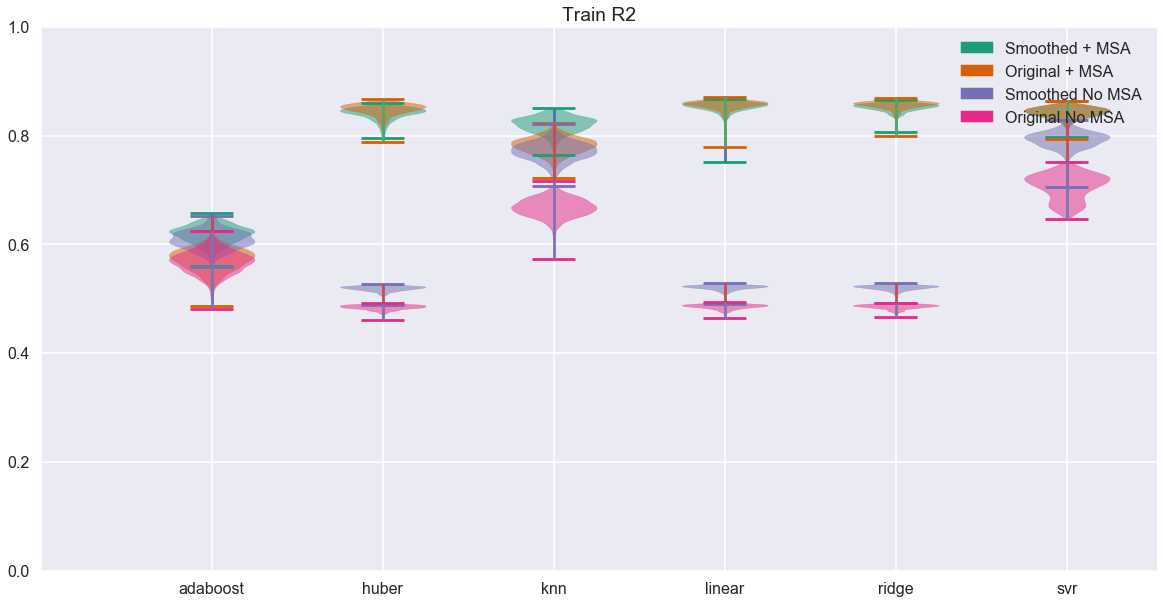

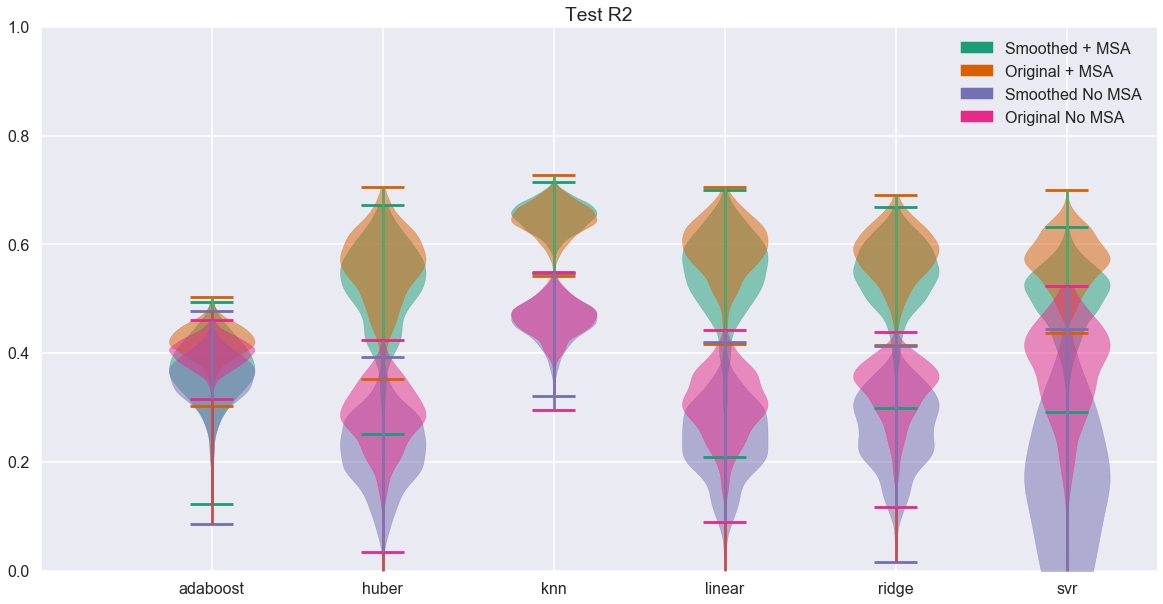

In [14]:
violin_plots([exp_1, exp_2, exp_3, exp_4],
             ['Train R2','Test R2'],
             experiment_name=['Smoothed + MSA','Original + MSA', 'Smoothed No MSA', 'Original No MSA'],
             center_zero=False)